In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [4]:
from job_utils.idxpckl import Indexed_Pickle

In [6]:
lasso = pd.read_pickle('/mnt/sdb1/finalfinal/lasso_df.dat')
mcp = pd.read_pickle('/mnt/sdb1/finalfinal/mcp_df.dat')
scad = pd.read_pickle('/mnt/sdb1/finalfinal/scad_df.dat')
en = pd.read_pickle('/mnt/sdb1/finalfinal/en_df.dat')

In [7]:
from plotting_utils import *

## FPR vs. FNR plots

In [8]:
kappa = np.unique(lasso['kappa'].values)
sparsity = np.unique(lasso['sparsity'].values)

In [9]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
markers = ['o', 's', '^']

In [10]:
list(lasso.keys())

['n_boots_est',
 'cov_idx',
 'n_boots_sel',
 'n_features',
 'reps',
 'cov_type',
 'est_score',
 'n_alphas',
 'sparsity',
 'kappa',
 'np_ratio',
 'index',
 'n_samples',
 'seed',
 'selection_method',
 'sa',
 'FNR',
 'FPR',
 'ee',
 'r2',
 'MSE',
 'betawidth']

/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


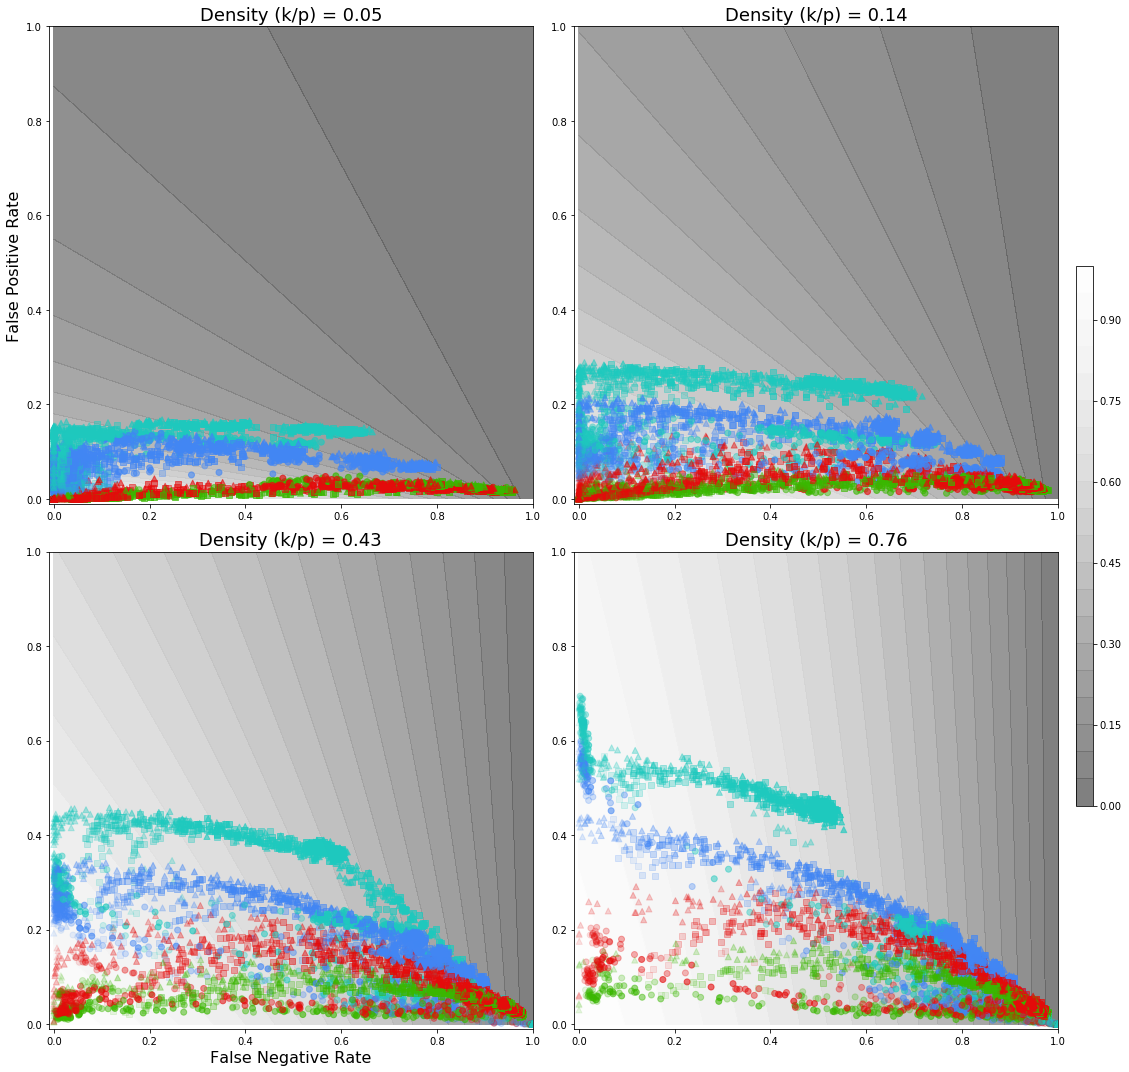

In [46]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 500
sparsity_ = [sparsity[3], sparsity[7], sparsity[11], sparsity[13]]
kappa_ = kappa
# Fix the number of samples!
np_ratio = 4
dframes = [lasso, mcp, scad, en]
selection_method = 'BIC'

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([-1, np.inf, 0.1]):   
            for cidx, df in enumerate(dframes):
                fil_df = apply_df_filters(df, sparsity=s, selection_method = selection_method, 
                                                kappa = k, betawidth=bw, np_ratio=np_ratio)
                a, scat = FNR_FPR_scatter(a, fil_df, cols[cidx], marker = markers[ii])
        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)

ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
plt.savefig('fprvfnr_BIC.pdf', bbox_inches = 'tight', pad_inches=0)

/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


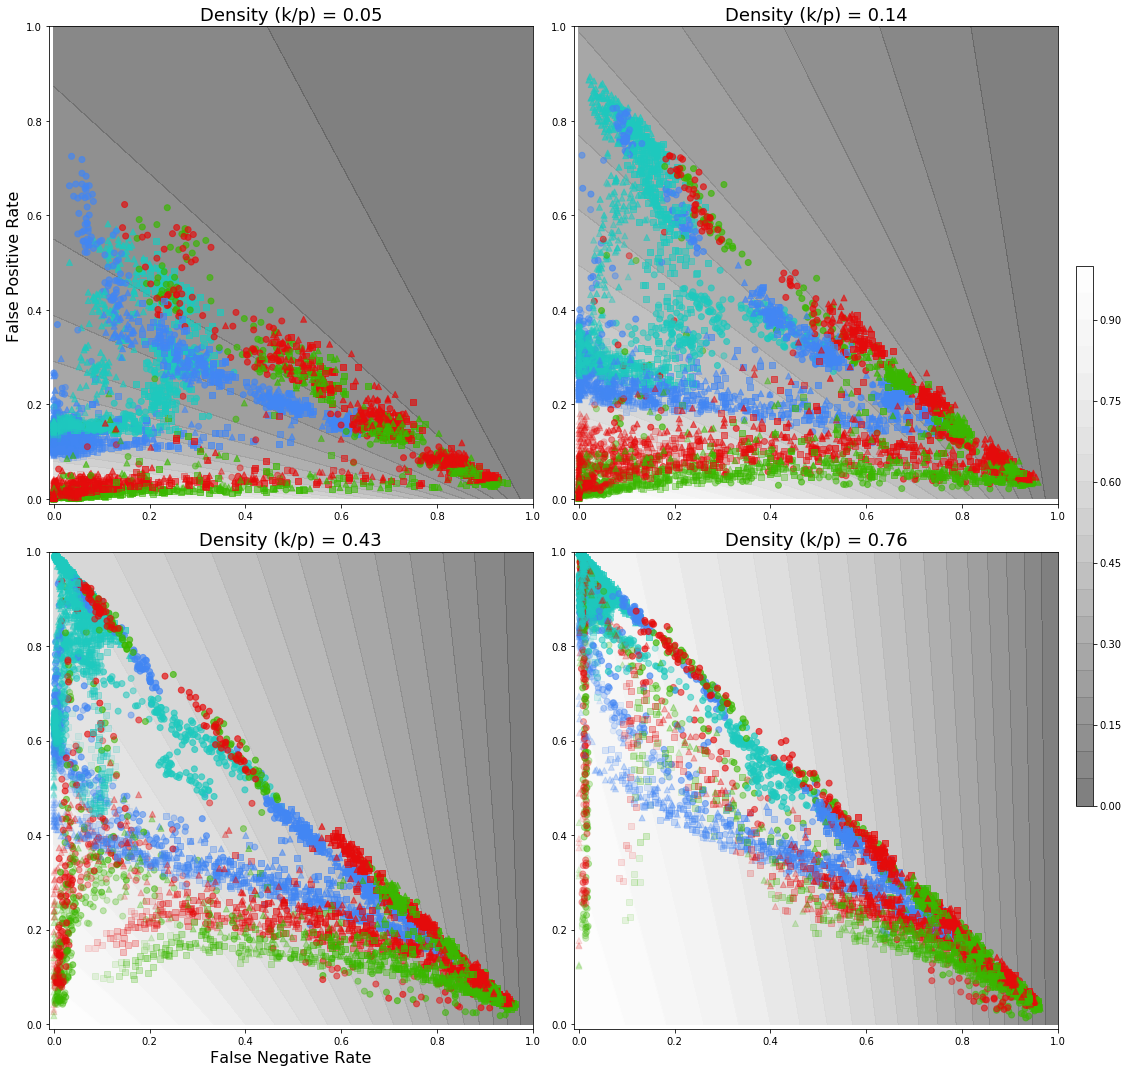

In [47]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))
scatters = []
n_features = 500
sparsity_ = [sparsity[3], sparsity[7], sparsity[11], sparsity[13]]
kappa_ = kappa
# Fix the number of samples!
np_ratio = 4
dframes = [lasso, mcp, scad, en]
selection_method = 'CV'

for i, s in enumerate(sparsity_):
    
    a = ax[np.unravel_index(i, (2, 2))]
    
    # Superimpose contours of constant selection accuracy
    xx = np.linspace(0, 1, 100)
    yy = np.linspace(0, 1, 100)
    z = np.zeros((100, 100))
    for ix, x in enumerate(xx):
        for iy, y in enumerate(yy):
            z[ix, iy] = 1 - ((1 - s)* y + s * x)/(s * (2 - x - y) + y) 
    
    cmap = plt.get_cmap('Greys_r')
    cmap_new = truncate_colormap(cmap, minval = 0.25)
    cs = a.contourf(xx, yy, z.T, 20, cmap = cmap_new, alpha = 0.75)

    # Set opacity via average correlation    
    for j, k in enumerate(kappa_):
        for ii, bw in enumerate([-1, np.inf, 0.1]):   
            for cidx, df in enumerate(dframes):
                fil_df = apply_df_filters(df, sparsity=s, selection_method = selection_method, 
                                                kappa = k, betawidth=bw, np_ratio=np_ratio)
                a, scat = FNR_FPR_scatter(a, fil_df, cols[cidx], marker = markers[ii])
        
    a.set_xlim([-0.01, 1])
    a.set_ylim([-0.01, 1])
    a.set_title('Density (k/p) = %.2f' % s, fontsize = 18)

ax[0, 0].set_ylabel('False Positive Rate', fontsize = 16)
ax[1, 0].set_xlabel('False Negative Rate', fontsize = 16)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(cs, cax = cax)
plt.tight_layout()
plt.savefig('fprvfnr_R2.pdf', bbox_inches = 'tight', pad_inches=0)

### What is driving the branching structure above?

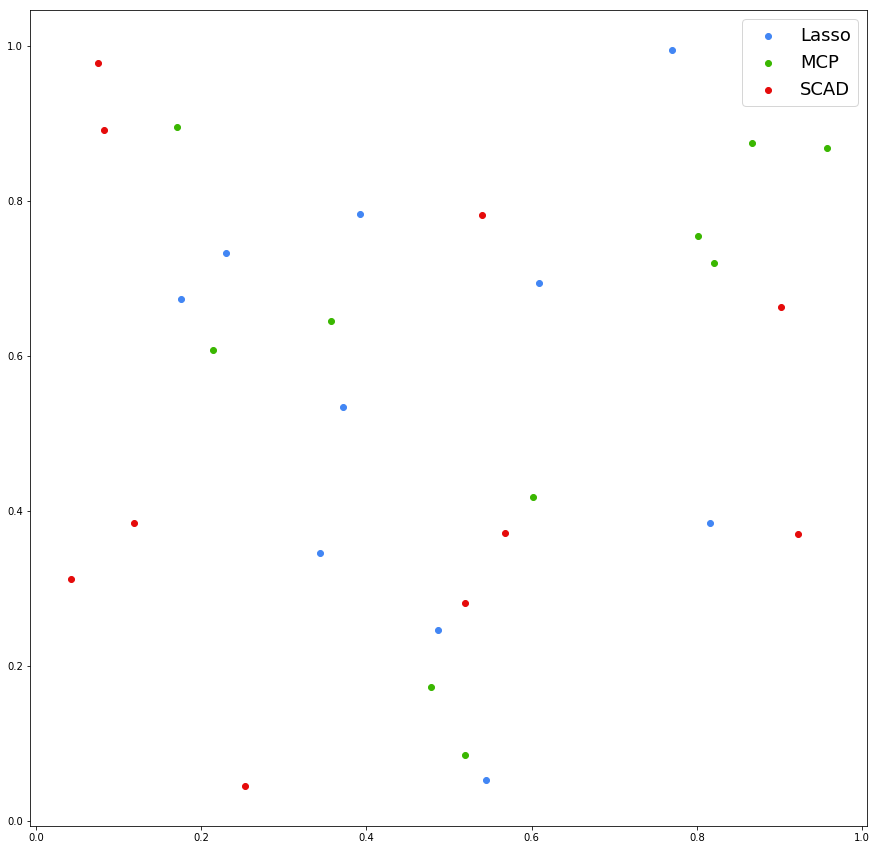

In [16]:
# Dummy plot to get a colormap
fig, ax = plt.subplots(figsize=(15, 15))
for cidx, df in enumerate(dframes):
    ax.scatter(np.random.random(10), np.random.random(10), c = cols[cidx])
plt.legend(['Lasso', 'MCP', 'SCAD'], fontsize=18)
plt.savefig('scatter_legend.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0], 'k']

In [12]:
# Linestyles
linestyles = ['solid', 'dashed', (0, (3, 1, 1, 1))] # densely dash dotted
# Marker styles
markers = ["o", "^", "s", "x", ">"]

selection_methods = ['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

# Group information criteria together, CV as dashed, and adaptive as densley dash dotted
pltstyles = [('solid', "o"), ('solid', "^"), ('dashed', 's'), (linestyles[2], 'x'), (linestyles[2], ">")]


In [ ]:
# Enumerate all the cov_params so that we can manually select a 
# few indices

In [17]:
cov_params = []
for idx in range(80): 
    cov_params.append(load_covariance(idx, params_only=True))
cov_params = pd.DataFrame(cov_params)

In [24]:
perturbed_params = []
for idx in range(80, 120):
    perturbed_params.append(load_covariance(idx, params_only=True))
perturbed_params = pd.DataFrame(perturbed_params)

In [19]:
c1 = apply_df_filters(cov_params, block_size=50, L = 1, t = 0)

In [22]:
c2 = apply_df_filters(cov_params, correlation=0, block_size=100, L =100)

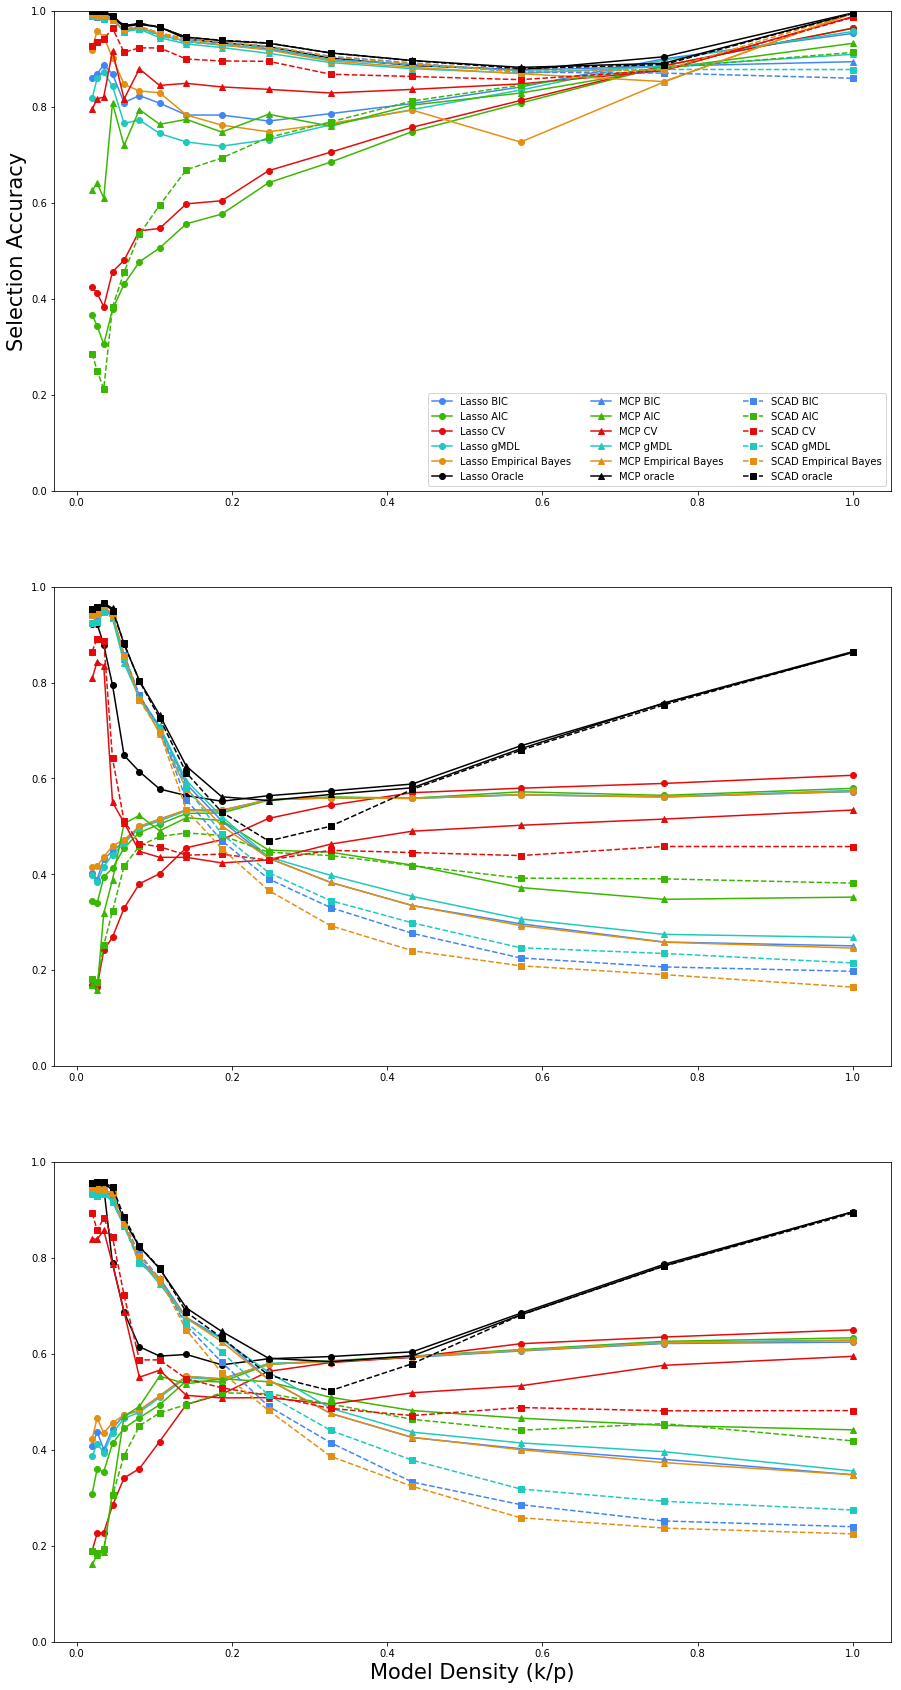

In [34]:
# For 3 different covariance matrices, plot selection accuracy vs sparsity for all algorithms and all selection methods
fig, ax = plt.subplots(3, 1, figsize = (15, 30))

# Manually selected cov_params
#cov_params = [[0.15811388, 50.0, 1.0, 0.0], [0.0, 100.0, 100.0, 0.8897894862254017], [0.15811388, 50.0, 100.0, 0.7972883364187614]]
cidx1 = 27
cidx2 = 38
cidx3 = 

# Fix the np_ratio, signal to noise, and betawidth
np_ratio = 16
kappa = 5
betawidth = np.inf

sparsity = np.unique(lasso['sparsity'].values)
dframes = [lasso, mcp, scad]

# Use the same colors for each algorithm, different line style/marker combinations for each selection method
colors = []

for i1 in range(len(cov_params)):
    
    a = ax[i1]
    
    for i2, df in enumerate(dframes):
        
        df_ = apply_df_filters(df, np_ratio = np_ratio, 
                               correlation = cov_params[i1][0],
                               block_size = cov_params[i1][1],
                               L = cov_params[i1][2],
                               t = cov_params[i1][3],
                               kappa = kappa,
                               betawidth=betawidth)


        for i3, sm in enumerate(selection_methods):
    
            df_sm = apply_df_filters(df_, selection_method = sm)

            # Now average over the remaining degrees of freedom
            s, yvals, yerr = marginalize(df_sm, 'sa', ['sparsity'])
            
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
ax[0].set_ylabel('Selection Accuracy', fontsize = 21)
ax[2].set_xlabel('Model Density (k/p)', fontsize = 21)
ax[0].legend(['Lasso BIC', 'Lasso AIC', 'Lasso CV', 'Lasso gMDL', 'Lasso Empirical Bayes', 'Lasso Oracle',
              'MCP BIC', 'MCP AIC', 'MCP CV', 'MCP gMDL', 'MCP Empirical Bayes', 'MCP oracle',
              'SCAD BIC', 'SCAD AIC', 'SCAD CV', 'SCAD gMDL', 'SCAD Empirical Bayes', 'SCAD oracle'], 
              ncol = 3, loc='lower right')
# plt.savefig('selection_method_comparisons.pdf', bbox_inches='tight', pad_inches=0)

# Standard vs. Perturbed matrices in each column

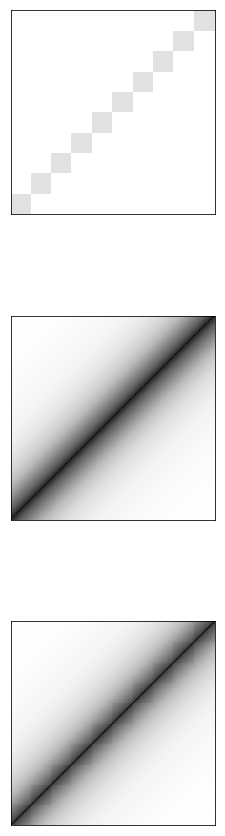

In [32]:
fig, ax = plt.subplots(3, 1, figsize = (7, 15))
cov_params = [[0.15811388, 50.0, 1.0, 0.0], [0.0, 100.0, 100.0, 0.8897894862254017], [0.15811388, 50.0, 100.0, 0.7972883364187614]]

for i in range(len(cov_params)): 
    
    block_size = int(cov_params[i][1])
    sigma = gen_covariance(500, cov_params[i][0], block_size, cov_params[i][2], cov_params[i][3]).T
    if i == 0:
        ax[i].pcolormesh(sigma.T, vmin = 0, vmax = 0.75, cmap = 'Greys')
    else:
        ax[i].pcolormesh(sigma.T, vmin = 0, vmax = 1, cmap = 'Greys')
    ax[i].set_aspect('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.subplots_adjust(hspace = 0.5)
plt.savefig('cov_reference.pdf', bbox_inches='tight', pad_inches=0)

In [36]:
np_ratios = np.unique(lasso['np_ratio'].values)

In [45]:
from mpl_toolkits.mplot3d import Axes3D

In [63]:
%matplotlib notebook

In [66]:
np_ratios

array([ 2,  4,  6,  8, 16], dtype=int64)

In [74]:
np.unique(lasso['kappa'].values)

array([1, 2, 5], dtype=int64)

<IPython.core.display.Javascript object>


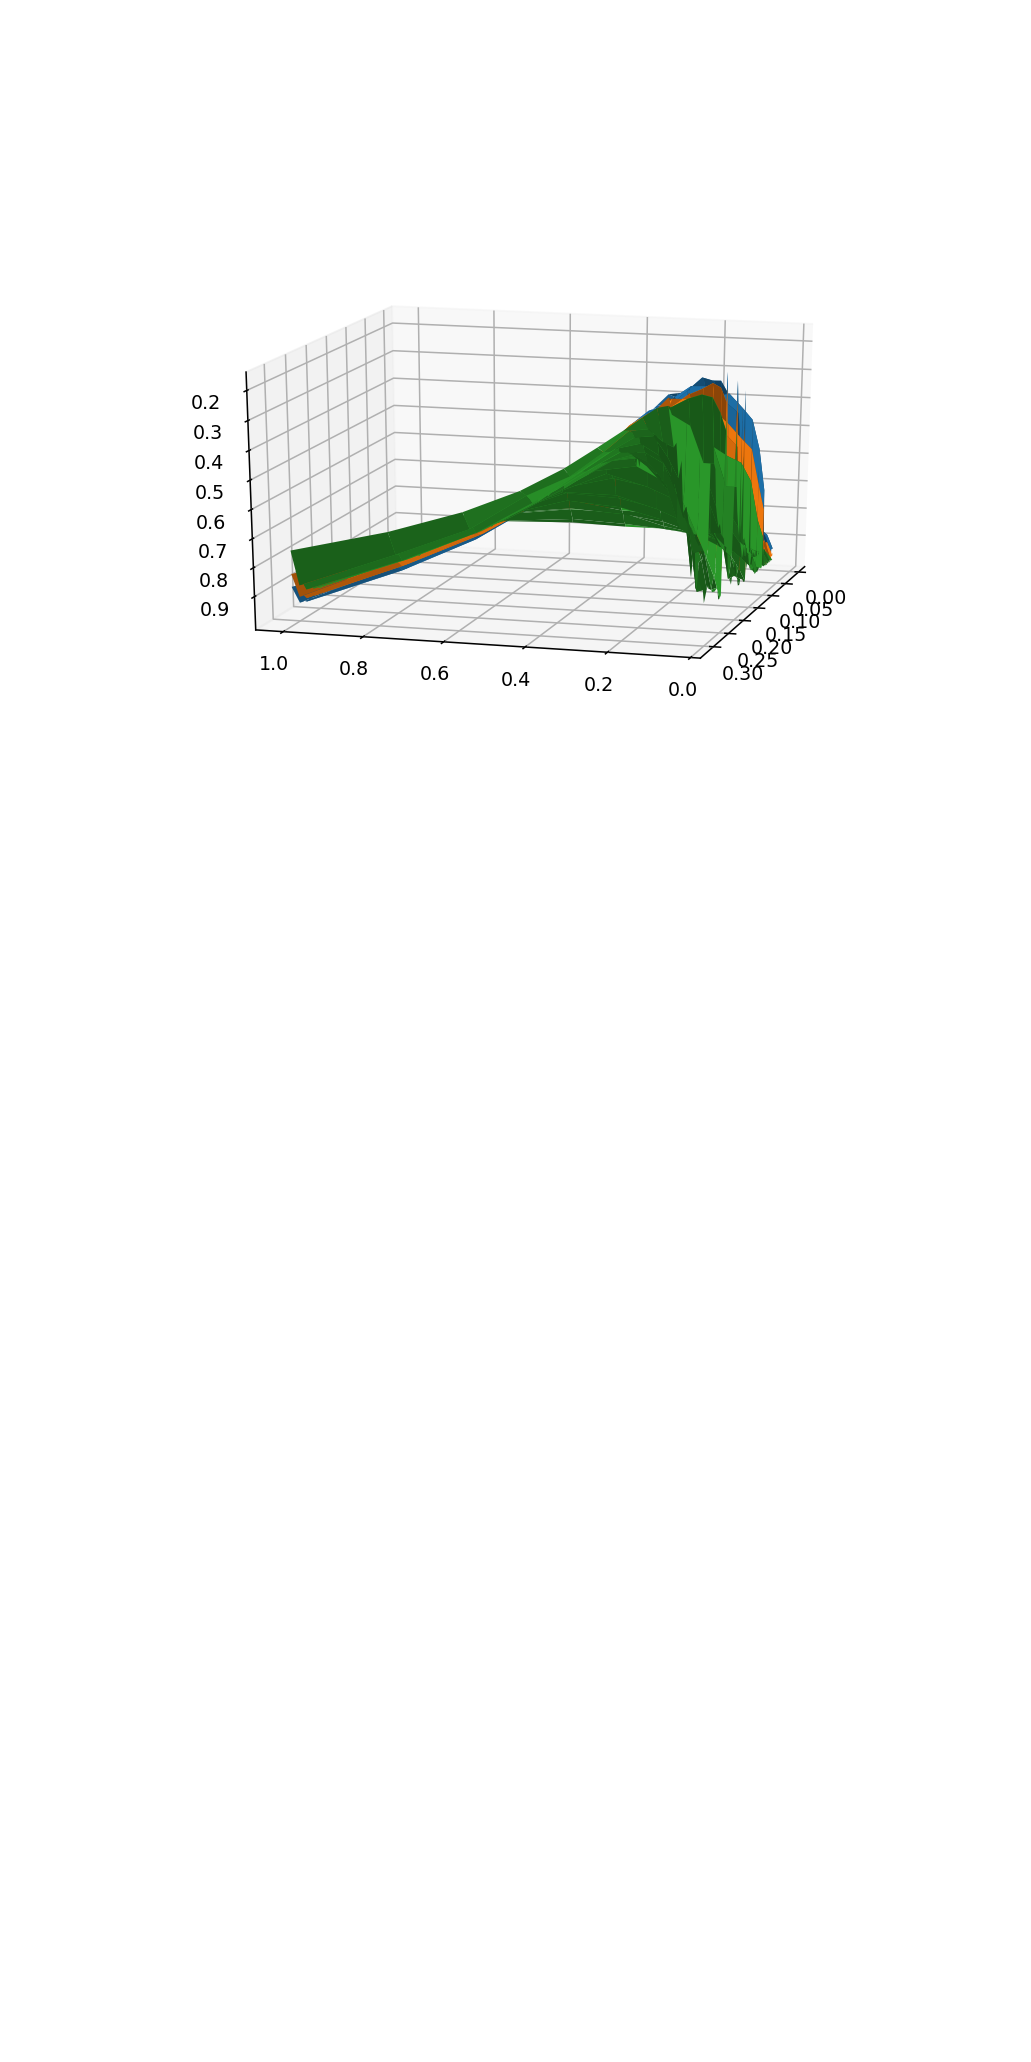

In [78]:
# Next plot type: Plot 2D surfaces of the oracle selection accuracy (achieved on at least 15/20 repetitions) for the different 
# n/p ratios vs. sparsity and average correlation

fig = plt.figure(figsize = (7.5, 15))

# Fix the signal to noise ratio for now 
np_ratio = 4

for i1, df in enumerate([lasso]):

    a = fig.add_subplot(3, 1, i1 + 1, projection='3d')
    for i2, kappa in enumerate([1, 2, 5]):
        df_ = apply_df_filters(df, kappa=kappa, np_ratio=np_ratio, betawidth=np.inf, selection_method='g')
        sparsity_corr_2D(a, df_, 'sa')

C:\Users\akumar\Anaconda3\envs\nse\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


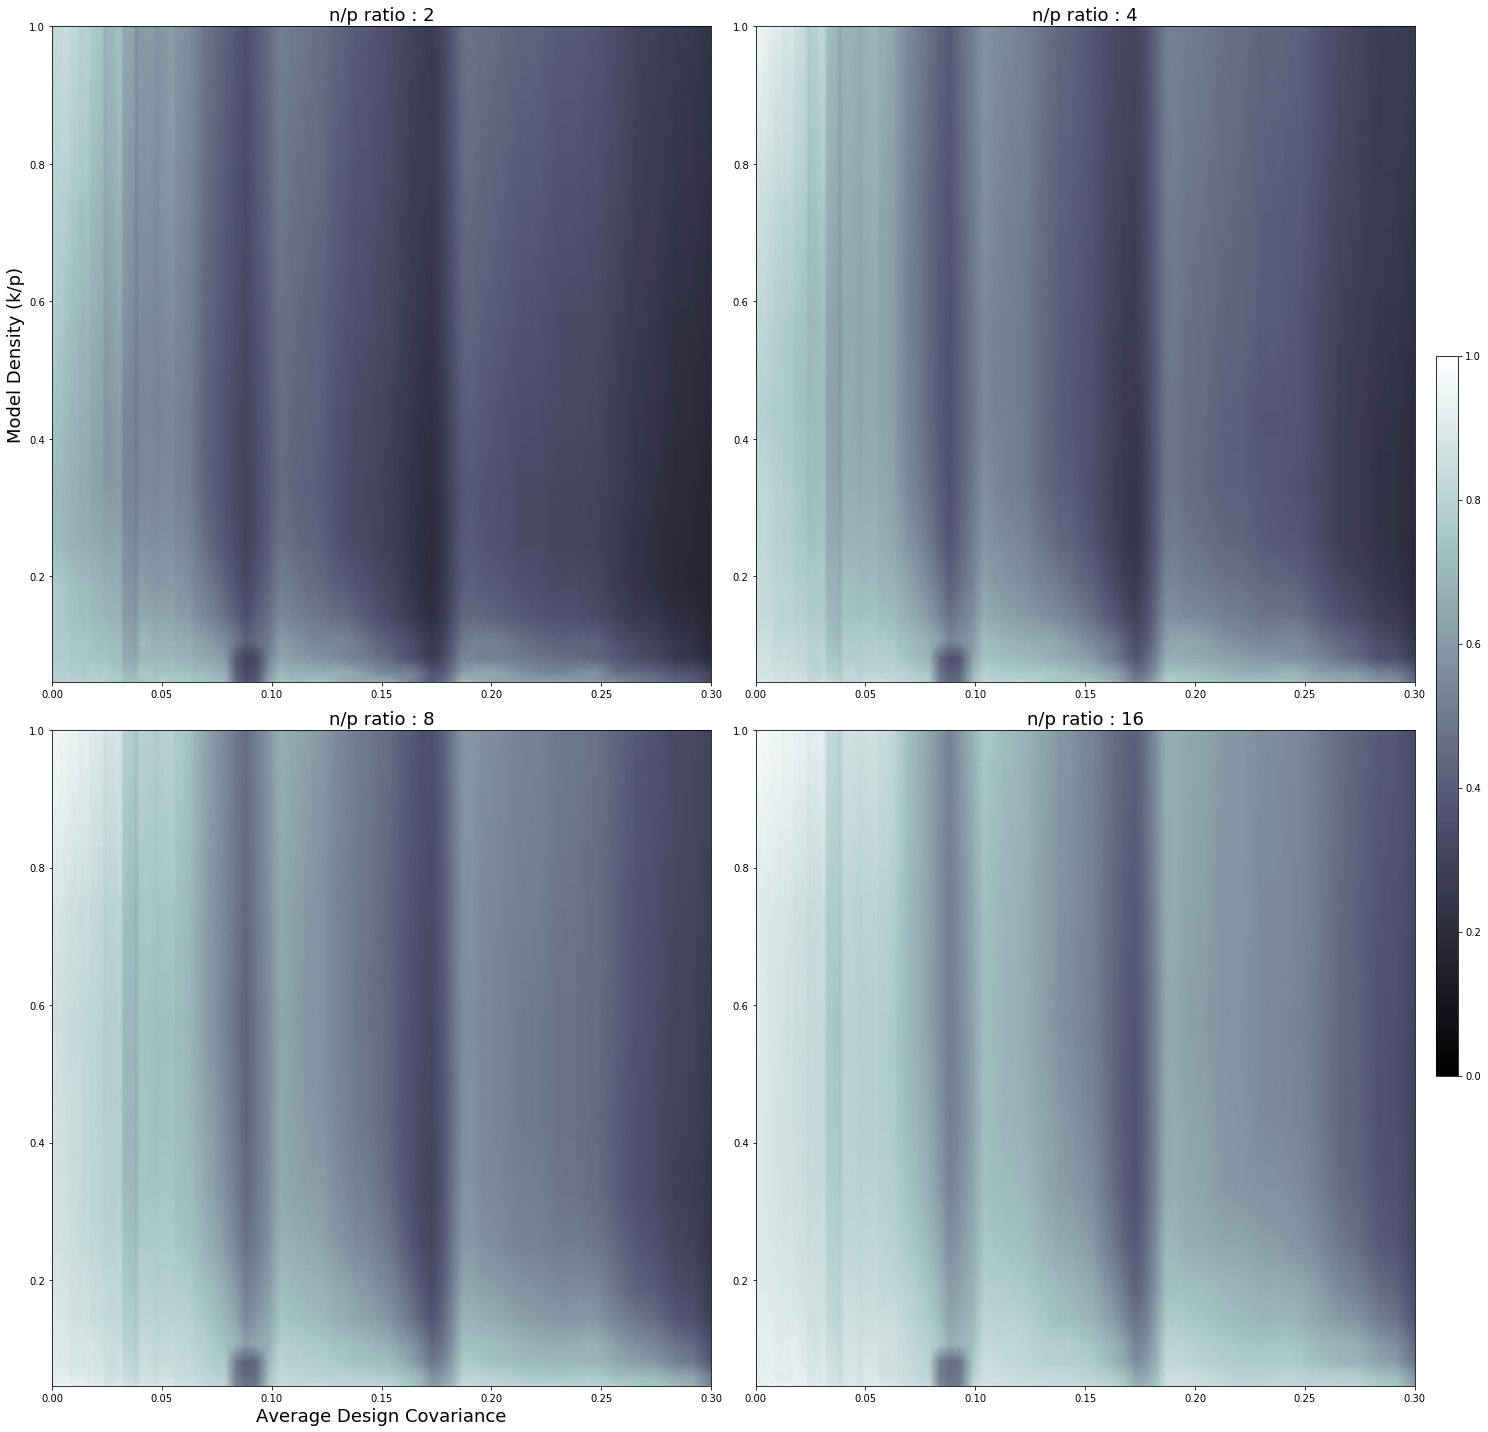

In [7]:
# Surfaces aren't really working out --> What we can do instead is to take the maximum (average) selection accuracy across all
# algorithms and plot colormaps as a function of sparsity and average correlation. Apply some smoothing to average correlation,
# and do some interpolation for sparsity. Then, plot these as panels for the the different n/p ratios OR signal to nosie, 
# depending on what exhibits greater variation

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

for i1, np_ratio in enumerate([2, 4, 8, 16]):
    df = apply_df_filters(mcp, np_ratio = np_ratio, betawidth = np.inf, kappa = 5)
    h = sparsity_corr_2D_2(ax[np.unravel_index(i1, (2, 2))], df, 'sa')
    ax[np.unravel_index(i1, (2, 2))].set_title('n/p ratio : %d' % np_ratio, fontsize = 18)
    
ax[0, 0].set_ylabel('Model Density (k/p)', fontsize = 18)
ax[1, 0].set_xlabel('Average Design Covariance', fontsize = 18)
cax = fig.add_axes([1, 0.25, 0.015, 0.5])
plt.colorbar(h, cax = cax)
plt.tight_layout()
plt.savefig('n_scaling.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Estimation bias/variance
# Selection variance

In [6]:
import h5py

In [8]:
# beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
#                   '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
#                   '/home/akumar/nse/data/sfn/scad_beta_hat.h5']
# beta_hat_paths = ['./lasso_beta_hat.h5', './mcp_beta_hat.h5', './scad_beta_hat.h5',
#                  './en_beta_hat.h5', './uoi_beta_hat.h5']
beta_hat_paths = ['./en_beta_hat.h5', './uoi_beta_hat.h5']


In [41]:
def calc_est_bias(dframe, beta_hat_path, beta_path, unravel_indices):
    
    values_of_interest = dframe[['sparsity', 'L', 't', 'correlation', 'block_size']].to_dict('records')
    unique_values, rep_idxs = group_dictionaries(values_of_interest, None)
    
    est_bias = np.zeros(len(rep_idxs))
    
    with h5py.File(beta_hat_path, 'r') as f:
        with h5py.File(beta_path, 'r') as g:
            for j, rep_idx in enumerate(rep_idxs):
                df_ = dframe.iloc[rep_idx]
                row_indices = np.array(list(df_.index))

                # Convert row indices to 2D indices
                if unravel_indices:
                    row_indices = np.unravel_index(row_indices, (f['beta_hat'].shape[0], f['beta_hat'].shape[1]))            

                    # Load the corresponding rows of beta hat
                    beta_hat = np.array([f['beta_hat'][row_indices[0][i], row_indices[1][i], :] 
                                         for i in range(row_indices[0].size)])

                    beta = np.array([g['beta'][row_indices[0][i], row_indices[1][i], :] 
                                     for i in range(row_indices[0].size)])
                else:
                    
                    beta_hat = np.array([f['beta_hat'][row_indices[i], :] for i in range(row_indices.size)])
                    beta = np.array([g['beta'][row_indices[i], :] for i in range(row_indices.size)])
                
                # Bias per element on the common support
                normalized_bias = np.zeros(beta.shape[0])
                for k in range(beta.shape[0]):
                    common_support = \
                    list(set(np.nonzero(beta[k, :])[0]).intersection(set(np.nonzero(beta_hat[k, :])[0])))
                    normalized_bias[k] = np.linalg.norm(beta_hat[k, common_support] - beta[k, common_support])/len(common_support)
                est_bias[j] = np.mean(normalized_bias)
#                est_bias[j] = np.linalg.norm(np.mean(beta_hat - beta, axis = 0))

    return est_bias    

In [32]:
def calc_est_variance(dframe, beta_hat_path, unravel_indices):
    
    values_of_interest = dframe[['sparsity', 'L', 't', 'correlation', 'block_size']].to_dict('records')
    unique_values, rep_idxs = group_dictionaries(values_of_interest, None)
    
    est_var = np.zeros(len(rep_idxs))
    
    with h5py.File(beta_hat_path) as f:
        
        for j, rep_idx in enumerate(rep_idxs):
            df_ = dframe.iloc[rep_idx]
            row_indices = np.array(list(df_.index))
            
            # Convert row indices to 2D indices
            if unravel_indices:
                row_indices = np.unravel_index(row_indices, (f['beta_hat'].shape[0], f['beta_hat'].shape[1]))            
    
                # Load the corresponding rows of beta hat
                beta_hat = np.array([f['beta_hat'][row_indices[0][i], row_indices[1][i], :] 
                                     for i in range(row_indices[0].size)])
            else:

                beta_hat = np.array([f['beta_hat'][row_indices[i], :] for i in range(row_indices.size)])
            
            est_var[j] = np.mean(np.diag(np.cov(beta_hat.T)))
    return est_var    

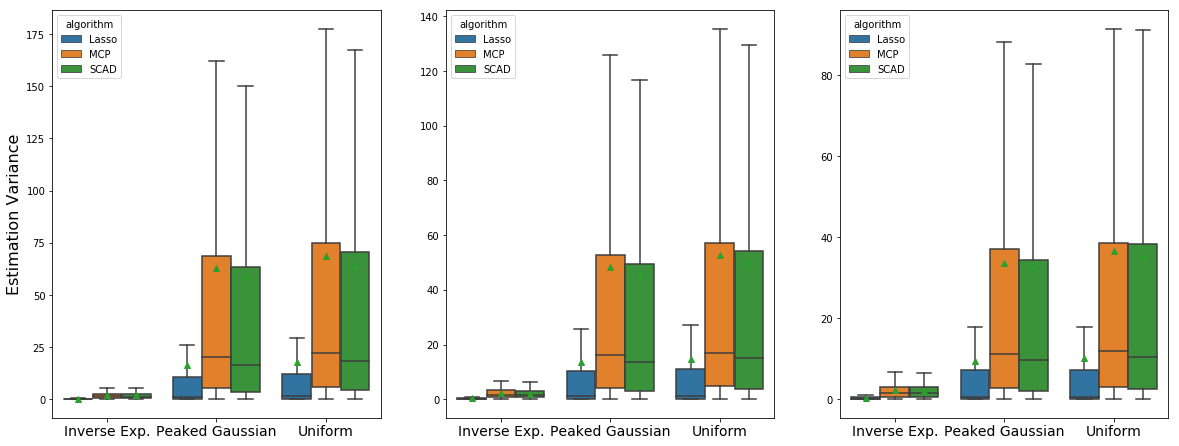

In [50]:
# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(1, 3, figsize = (20, 7.5))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad]
dframe_names = ['Lasso', 'MCP', 'SCAD']
beta_path = '/home/akumar/nse/data/sfn/sfn_beta.h5'

beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5']

# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_variance(df, beta_hat_paths[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Variance', fontsize = 16)
plt.savefig('estvar.pdf', bbox_inches='tight', pad_inches=0)

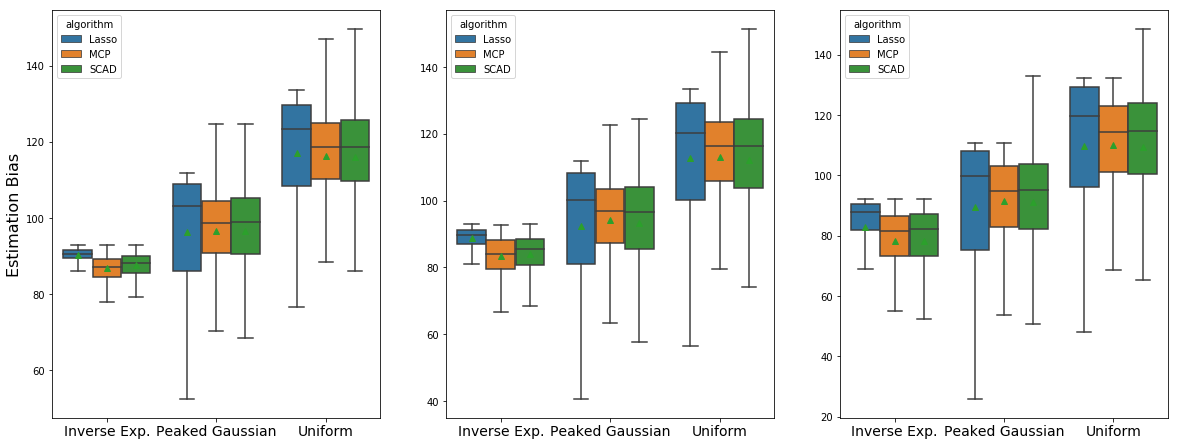

In [74]:
# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(1, 3, figsize = (20, 7.5))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad]
dframe_names = ['Lasso', 'MCP', 'SCAD']
beta_path = ['/home/akumar/nse/data/sfn/lasso2_beta.h5',
             '/home/akumar/nse/data/sfn/mcp2_beta.h5',
             '/home/akumar/nse/data/sfn/scad2_beta.h5']

beta_hat_paths = ['/home/akumar/nse/data/sfn/lasso_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/mcp_beta_hat.h5',
                  '/home/akumar/nse/data/sfn/scad_beta_hat.h5']

# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_bias(df, beta_hat_paths[i3], beta_path[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Bias', fontsize = 16)


# Estimation variance 

# Select indices
for i1, k in enumerate(kappa):
    est_var = []
    for i2, bw in enumerate(betawidth):
        for i3, dframe in enumerate(dframes):
            df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                                  betawidth=bw, selection_method=selection_method)
            # Calculate variances across reps
            values = calc_est_variance(df, beta_hat_paths[i3])
            dat_list = [[dframe_names[i3], bw, value] for value in values]
            est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    sns.boxplot(x='betawidth', y ='est_var', hue='algorithm', data=plt_df, ax = ax[i1],
                showmeans=True, showfliers=False)
    ax[i1].set_xlabel('')
    ax[i1].set_ylabel('')
    ax[i1].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[0].set_ylabel('Estimation Variance', fontsize = 16)



plt.savefig('estbias.pdf', bbox_inches='tight', pad_inches=0)

In [35]:
betawidth

array([-1. ,  0.1,  inf])

Text(0, 0.5, 'Estimation Variance')

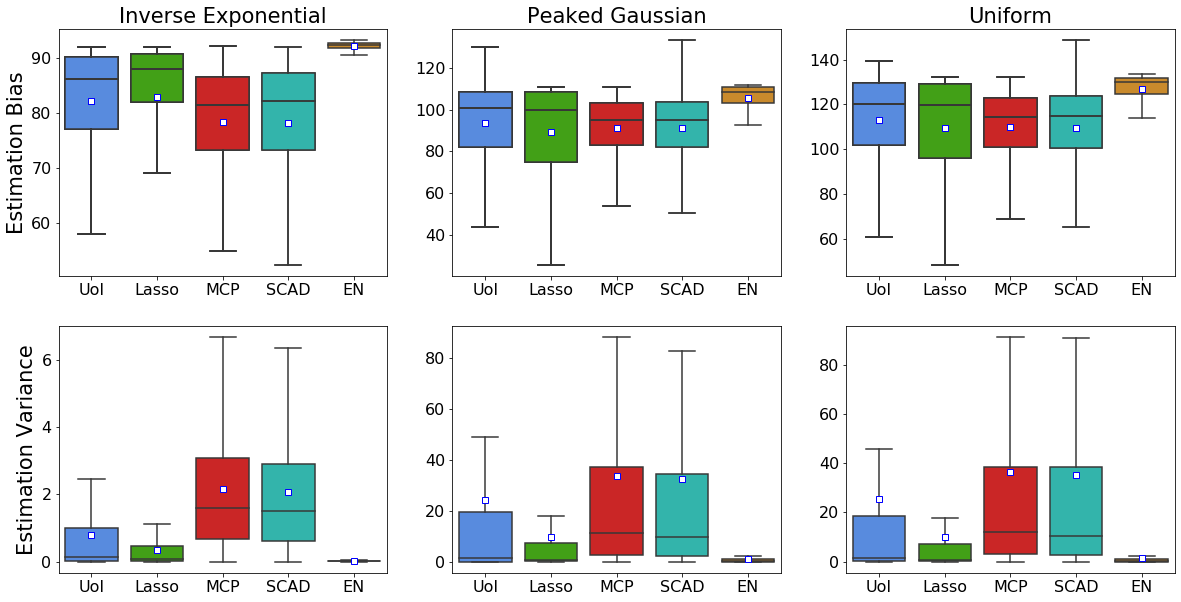

In [14]:
# Combine both plots into a single one

# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
kappa = np.unique(lasso['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [uoi, lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]

pal_colors = cols
#dframe_names = ['UoI', 'Elastic Net']
# beta_path = ['./uoi_beta.h5',
#             './lasso2_beta.h5',
#              './mcp2_beta.h5',
#              './scad2_beta.h5',
#             './en_beta.h5']

# beta_hat_paths = ['./uoi_beta_hat.h5',
#                   './lasso_beta_hat.h5',
#                   './mcp_beta_hat.h5',
#                   './scad_beta_hat.h5',
#                     './en_beta_hat.h5']

beta_path = ['/mnt/sdb1/uoi_beta.h5',
            '/mnt/sdb1/lasso2_beta.h5',
             '/mnt/sdb1/mcp2_beta.h5',
             '/mnt/sdb1/scad2_beta.h5',
            '/mnt/sdb1/en_beta.h5']

beta_hat_paths = ['/mnt/sdb1/uoi_beta_hat.h5',
                  '/mnt/sdb1/lasso_beta_hat.h5',
                  '/mnt/sdb1/mcp_beta_hat.h5',
                  '/mnt/sdb1/scad_beta_hat.h5',
                  '/mnt/sdb1/en_beta_hat.h5']


unravel_indices = [False, True, True, True, False]
# Estimation Bias

# Select indices
for i2, bw in enumerate(betawidth):
    est_var = []
    for i3, dframe in enumerate(dframes):
        df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                              betawidth=bw, selection_method=selection_method)
        # Calculate variances across reps
        values = calc_est_bias(df, beta_hat_paths[i3], beta_path[i3], unravel_indices[i3])
        dat_list = [[dframe_names[i3], bw, value] for value in values]
        est_var.extend(dat_list)

        # Create new dataframe for plotting
        plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
        bpl = sns.boxplot(x='algorithm', y ='est_var', data=plt_df, ax = ax[0, i2],
                    showmeans=True, showfliers=False, palette = sns.color_palette(pal_colors),
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
#        bpl.legend_.remove()
        ax[0, i2].set_xlabel('')
        ax[0, i2].set_ylabel('')
        ax[0, i2].set_xticklabels(dframe_names)
        ax[0, i2].tick_params(axis="y", labelsize=16)
        ax[0, i2].tick_params(axis="x", labelsize=16)
ax[0, 0].set_ylabel('Estimation Bias', fontsize = 21)
ax[0, 0].set_title('Inverse Exponential', fontsize = 21)
ax[0, 1].set_title('Peaked Gaussian', fontsize = 21)
ax[0, 2].set_title('Uniform', fontsize = 21)
# Estimation variance 

# Select indices
for i2, bw in enumerate(betawidth):
    est_var = []
    for i3, dframe in enumerate(dframes):
        df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, 
                              betawidth=bw, selection_method=selection_method)
        # Calculate variances across reps
        values = calc_est_variance(df, beta_hat_paths[i3], unravel_indices[i3])
        dat_list = [[dframe_names[i3], bw, value] for value in values]
        est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    bpl = sns.boxplot(x='algorithm', y ='est_var', data=plt_df, ax = ax[1, i2],
                showmeans=True, showfliers=False, palette = sns.color_palette(pal_colors),
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
    #    bpl.legend_.remove()
    ax[1, i2].set_xlabel('')
    ax[1, i2].set_ylabel('')
    ax[1, i2].set_xticklabels(dframe_names)
    ax[1, i2].tick_params(axis="y", labelsize=16)
    ax[1, i2].tick_params(axis="x", labelsize=16)
    #    ax[1, i2].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[1, 0].set_ylabel('Estimation Variance', fontsize = 21)
#plt.savefig('est.pdf', bbox_inches='tight', pad_inches=0)

In [22]:
np.unique(lasso['sparsity'].values) == np.unique(uoi['sparsity'].values)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [23]:
sparsity[3]

0.046248217264093394

Text(0, 0.5, 'Estimation Variance')

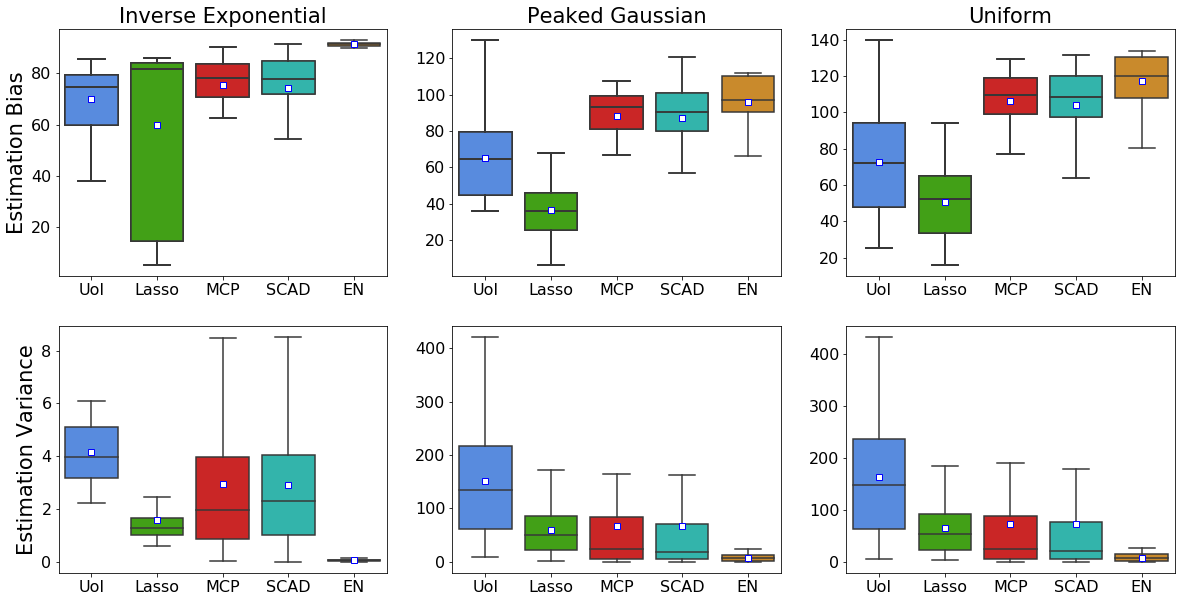

In [25]:
# The issue is likely due to the other algorithms getting to be
# averaged across many more repetititions

# Put things on a level playing field

# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
kappa = np.unique(uoi['kappa'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [uoi, lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]

pal_colors = cols
#dframe_names = ['UoI', 'Elastic Net']
# beta_path = ['./uoi_beta.h5',
#             './lasso2_beta.h5',
#              './mcp2_beta.h5',
#              './scad2_beta.h5',
#             './en_beta.h5']

# beta_hat_paths = ['./uoi_beta_hat.h5',
#                   './lasso_beta_hat.h5',
#                   './mcp_beta_hat.h5',
#                   './scad_beta_hat.h5',
#                     './en_beta_hat.h5']

beta_path = ['/mnt/sdb1/uoi_beta.h5',
            '/mnt/sdb1/lasso2_beta.h5',
             '/mnt/sdb1/mcp2_beta.h5',
             '/mnt/sdb1/scad2_beta.h5',
            '/mnt/sdb1/en_beta.h5']

beta_hat_paths = ['/mnt/sdb1/uoi_beta_hat.h5',
                  '/mnt/sdb1/lasso_beta_hat.h5',
                  '/mnt/sdb1/mcp_beta_hat.h5',
                  '/mnt/sdb1/scad_beta_hat.h5',
                  '/mnt/sdb1/en_beta_hat.h5']


unravel_indices = [False, True, True, True, False]
# Estimation Bias

# Select indices
for i2, bw in enumerate(betawidth):
    est_var = []
    for i3, dframe in enumerate(dframes):
        df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity = sparsity[-1],
                              betawidth=bw, selection_method=selection_method)
        # Calculate variances across reps
        values = calc_est_bias(df, beta_hat_paths[i3], beta_path[i3], unravel_indices[i3])
        dat_list = [[dframe_names[i3], bw, value] for value in values]
        est_var.extend(dat_list)

        # Create new dataframe for plotting
        plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
        bpl = sns.boxplot(x='algorithm', y ='est_var', data=plt_df, ax = ax[0, i2],
                    showmeans=True, showfliers=False, palette = sns.color_palette(pal_colors),
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
#        bpl.legend_.remove()
        ax[0, i2].set_xlabel('')
        ax[0, i2].set_ylabel('')
        ax[0, i2].set_xticklabels(dframe_names)
        ax[0, i2].tick_params(axis="y", labelsize=16)
        ax[0, i2].tick_params(axis="x", labelsize=16)
ax[0, 0].set_ylabel('Estimation Bias', fontsize = 21)
ax[0, 0].set_title('Inverse Exponential', fontsize = 21)
ax[0, 1].set_title('Peaked Gaussian', fontsize = 21)
ax[0, 2].set_title('Uniform', fontsize = 21)
# Estimation variance 

# Select indices
for i2, bw in enumerate(betawidth):
    est_var = []
    for i3, dframe in enumerate(dframes):
        df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity=sparsity[-1], 
                              betawidth=bw, selection_method=selection_method)
        # Calculate variances across reps
        values = calc_est_variance(df, beta_hat_paths[i3], unravel_indices[i3])
        dat_list = [[dframe_names[i3], bw, value] for value in values]
        est_var.extend(dat_list)

    # Create new dataframe for plotting
    plt_df = pd.DataFrame(est_var, columns=['algorithm', 'betawidth', 'est_var'])
    bpl = sns.boxplot(x='algorithm', y ='est_var', data=plt_df, ax = ax[1, i2],
                showmeans=True, showfliers=False, palette = sns.color_palette(pal_colors),
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
    #    bpl.legend_.remove()
    ax[1, i2].set_xlabel('')
    ax[1, i2].set_ylabel('')
    ax[1, i2].set_xticklabels(dframe_names)
    ax[1, i2].tick_params(axis="y", labelsize=16)
    ax[1, i2].tick_params(axis="x", labelsize=16)
    #    ax[1, i2].set_xticklabels(['Inverse Exp.', 'Peaked Gaussian', 'Uniform'], fontsize = 14)

ax[1, 0].set_ylabel('Estimation Variance', fontsize = 21)
#plt.savefig('est.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Likely explanation: Specific matrices causing huge problems

/home/akumar/anaconda3/envs/nse/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Estimation Variance')

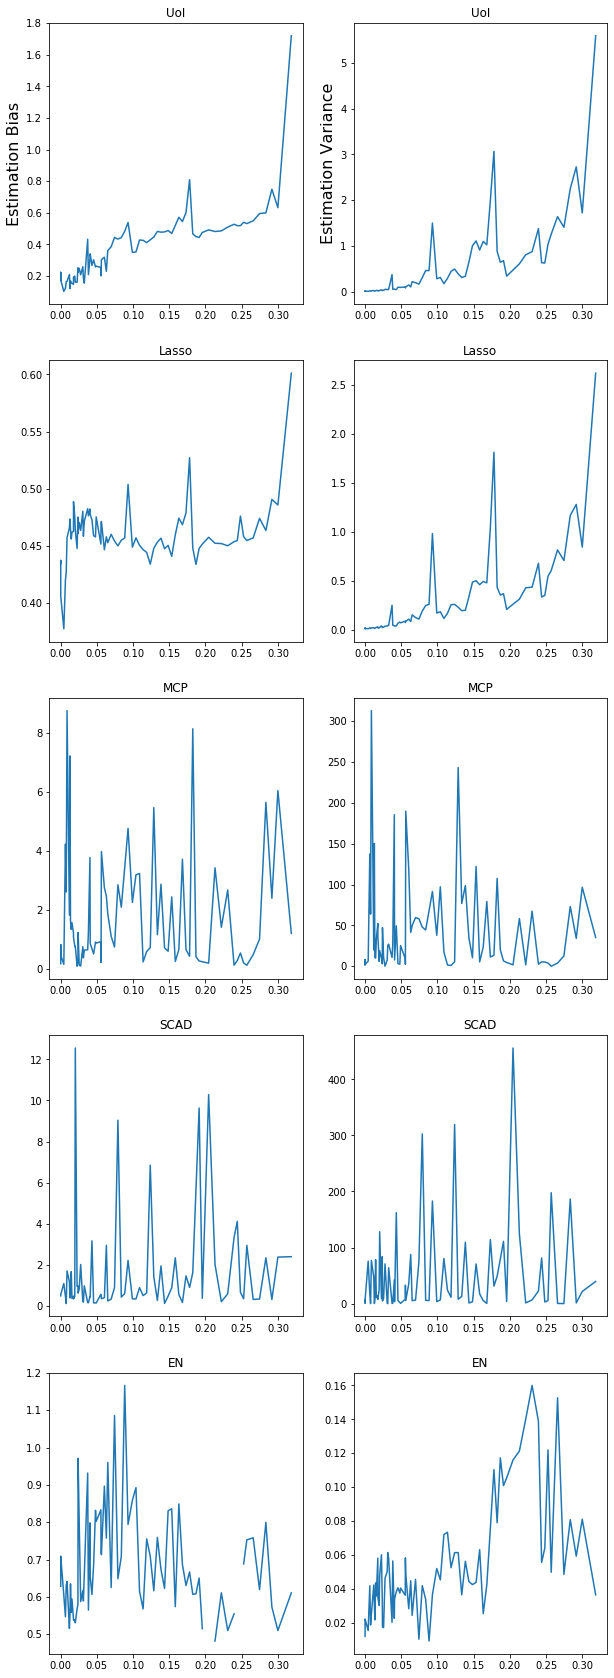

In [44]:

# Put things on a level playing field

# Plot bar for the different algorithms, averaged over all instances

fig, ax = plt.subplots(5, 2, figsize = (10, 30))

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
kappa = np.unique(uoi['kappa'].values)
bw = np.inf
selection_method = 'BIC'

dframes = [uoi, lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]

pal_colors = cols
#dframe_names = ['UoI', 'Elastic Net']
# beta_path = ['./uoi_beta.h5',
#             './lasso2_beta.h5',
#              './mcp2_beta.h5',
#              './scad2_beta.h5',
#             './en_beta.h5']

# beta_hat_paths = ['./uoi_beta_hat.h5',
#                   './lasso_beta_hat.h5',
#                   './mcp_beta_hat.h5',
#                   './scad_beta_hat.h5',
#                     './en_beta_hat.h5']

beta_path = ['/mnt/sdb1/uoi_beta.h5',
            '/mnt/sdb1/lasso2_beta.h5',
             '/mnt/sdb1/mcp2_beta.h5',
             '/mnt/sdb1/scad2_beta.h5',
            '/mnt/sdb1/en_beta.h5']

beta_hat_paths = ['/mnt/sdb1/uoi_beta_hat.h5',
                  '/mnt/sdb1/lasso_beta_hat.h5',
                  '/mnt/sdb1/mcp_beta_hat.h5',
                  '/mnt/sdb1/scad_beta_hat.h5',
                  '/mnt/sdb1/en_beta_hat.h5']


unravel_indices = [False, True, True, True, False]

# Estimation Bias
est_var = []
for i3, dframe in enumerate(dframes):
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity = sparsity[5],
                          betawidth=bw, selection_method=selection_method)

    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = np.zeros(len(ucp))
    for cidx, cp in enumerate(ucp):
        df_ = apply_df_filters(df, **cp)
        values[cidx] = calc_est_bias(df_, beta_hat_paths[i3], beta_path[i3], unravel_indices[i3])
    
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    ax[i3, 0].plot(avg_cov[cov_order], values[cov_order])
    ax[i3, 0].set_title(dframe_names[i3])
    
ax[0, 0].set_ylabel('Estimation Bias', fontsize = 16)

# Estimation variance 

# Select indices
for i3, dframe in enumerate(dframes):
    df = apply_df_filters(dframe, kappa=k, np_ratio=np_ratio, sparsity=sparsity[5], 
                          betawidth=bw, selection_method=selection_method)

    # Plot by unique_cov_params
    ucp, cidxs = unique_cov_params(df)
    values = np.zeros(len(ucp))
    for cidx, cp in enumerate(ucp):
        df_ = apply_df_filters(df, **cp)
        values[cidx] = calc_est_variance(df_, beta_hat_paths[i3], unravel_indices[i3])
    
    # order by average correlation
    avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
    cov_order = np.argsort(avg_cov)
    ax[i3, 1].plot(avg_cov[cov_order], values[cov_order])
    ax[i3, 1].set_title(dframe_names[i3])
    
ax[0, 1].set_ylabel('Estimation Variance', fontsize = 16)
#plt.savefig('est.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Another sanity check to do is R^2 --> what's up with SCAD/MCP's huge bias/variance? Can we make UoI more 
# competitive with regards to bias/variance with 48 estimation bootstraps as opposed to 24?